### Step 1: Data Collection

Collect a labeled dataset of infected and uninfected cell images, then divide the dataset into training, validation, and test sets.

Use `os` and `pillow` navigate the data directories and load tha images

note: removed thumb.db from directories

In [5]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

# Set the path to the data directory
data_dir = './cell_images'

# Create a list of image paths and corresponding labels
image_paths = []
labels = []

parasitized_dir = os.path.join(data_dir, 'Parasitized')
for img_file in os.listdir(parasitized_dir):
    img_path = os.path.join(parasitized_dir, img_file)
    image_paths.append(img_path)
    labels.append(1)  # Parasitized is labeled 1

uninfected_dir = os.path.join(data_dir, 'Uninfected')
for img_file in os.listdir(uninfected_dir):
    img_path = os.path.join(uninfected_dir, img_file)
    image_paths.append(img_path)
    labels.append(0)  # Uninfected is labeled 0

# Split the dataset into training, validation, and test sets
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, stratify=labels, random_state=42)
train_paths, val_paths, train_labels, val_labels = train_test_split(train_paths, train_labels, test_size=0.2, stratify=train_labels, random_state=42)

# Preprocess the images
img_size = (64, 64)

def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize(img_size)
    img = np.array(img)
    img = img / 255.0  # Normalize pixel values
    return img

train_images = [preprocess_image(img_path) for img_path in train_paths]
val_images = [preprocess_image(img_path) for img_path in val_paths]
test_images = [preprocess_image(img_path) for img_path in test_paths]


### Step 2: Data Preprocessing

Standardize the size and color of the images and normalize the pixel values. 

Use  `pillow` standardize and normalize the images

### Step 3: Feature extraction

In [7]:
from skimage.feature import hog

# Extract HOG features from the images
train_features = [hog(img, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2), channel_axis=-1) for img in train_images]
val_features = [hog(img, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2), channel_axis=-1) for img in val_images]
test_features = [hog(img, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2), channel_axis=-1) for img in test_images]

### 

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define a simple CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(np.array(train_images), np.array(train_labels), 
                    validation_data=(np.array(val_images), np.array(val_labels)), 
                    epochs=10, batch_size=32)

2023-04-10 22:34:58.787874: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
552/552 [==============================] - 46s 81ms/step - loss: 0.3293 - accuracy: 0.8453 - val_loss: 0.1798 - val_accuracy: 0.9522
Epoch 2/10
552/552 [==============================] - 44s 80ms/step - loss: 0.1483 - accuracy: 0.9533 - val_loss: 0.1536 - val_accuracy: 0.9492
Epoch 3/10
552/552 [==============================] - 44s 79ms/step - loss: 0.1320 - accuracy: 0.9563 - val_loss: 0.1280 - val_accuracy: 0.9596
Epoch 4/10
552/552 [==============================] - 44s 79ms/step - loss: 0.1212 - accuracy: 0.9589 - val_loss: 0.1272 - val_accuracy: 0.9567
Epoch 5/10
552/552 [==============================] - 44s 80ms/step - loss: 0.1127 - accuracy: 0.9621 - val_loss: 0.1274 - val_accuracy: 0.9590
Epoch 6/10
552/552 [==============================] - 44s 79ms/step - loss: 0.1005 - accuracy: 0.9649 - val_loss: 0.1328 - val_accuracy: 0.9576
Epoch 7/10
552/552 [==============================] - 43s 78ms/step - loss: 0.0890 - accuracy: 0.9690 - val_loss: 0.2591 - val_accuracy:

In [ ]:
# Save the model
model.save('malaria_detection_model.h5')

In [10]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(np.array(test_images), np.array(test_labels))

print('Test accuracy:', test_acc)

173/173 [==============================] - 2s 13ms/step - loss: 0.1831 - accuracy: 0.9537
Test accuracy: 0.9537373185157776


In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the predicted labels for the test set
test_predictions = model.predict_classes(np.array(test_images))

# Generate the confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)

# Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, cmap='Blues')

AttributeError: 'Sequential' object has no attribute 'predict_classes'

In [14]:
from sklearn.metrics import precision_score, recall_score

# Calculate precision and recall on the test set
test_predictions = model.predict(np.array(test_images))
test_predictions = (test_predictions > 0.5).astype(int)
precision = precision_score(test_labels, test_predictions)
recall = recall_score(test_labels, test_predictions)

print('Precision:', precision)
print('Recall:', recall)


173/173 [==============================] - 2s 13ms/step
Precision: 0.9516070783676418
Recall: 0.9560957910014514


173/173 [==============================] - 3s 15ms/step


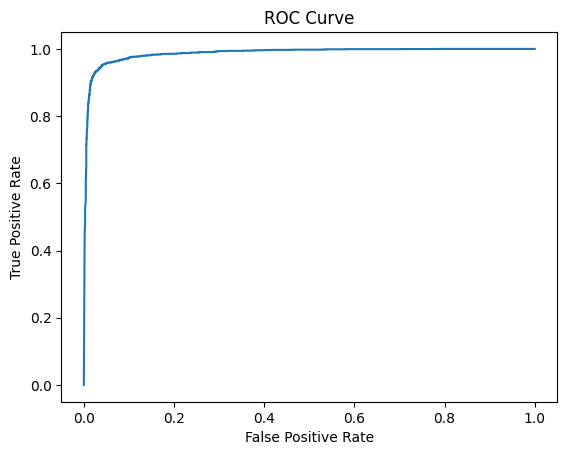

AUC: 0.9873162341670159


In [15]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calculate the predicted probabilities on the test set
test_predictions = model.predict(np.array(test_images))

# Calculate the false positive rate and true positive rate for different thresholds
fpr, tpr, thresholds = roc_curve(test_labels, test_predictions)

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Calculate the area under the ROC curve
auc = roc_auc_score(test_labels, test_predictions)
print('AUC:', auc)